# ARIMA Demand Forecast

In [1]:
import pandas as pd
import numpy as np
import time 
import plotly.graph_objs as go 
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm 
import scipy.stats as stats
from sklearn.model_selection import train_test_split
import pmdarima as pm
from datetime import timedelta 

import warnings
warnings.filterwarnings('ignore')
sns.set_style("white")

## Exploration

In [2]:
fivemindemand = pd.read_csv("data/fivemindemand.csv")
fivemindemand.set_index("time", inplace=True)
fivemindemand.index = pd.to_datetime(fivemindemand.index)
fivemindemand

,avg_power_demand_kW,energy_demand_kWh,peak_power_kW,day,month
time,,,,,
2020-11-05 10:30:00,0.879,0.07325,0.879,Thursday,November
2020-11-05 10:35:00,0.879,0.07325,0.879,Thursday,November
2020-11-05 10:40:00,0.879,0.07325,0.879,Thursday,November
2020-11-05 10:45:00,0.879,0.07325,0.879,Thursday,November
2020-11-05 10:50:00,0.879,0.07325,0.879,Thursday,November
...,...,...,...,...,...
2024-05-05 21:00:00,0.000,0.00000,0.000,Sunday,May
2024-05-05 21:05:00,0.000,0.00000,0.000,Sunday,May
2024-05-05 21:10:00,0.000,0.00000,0.000,Sunday,May


### Granularity Adjustment

For the purposes of time series analysis, a 24-hour peak power granularity might work better; as it stands, 5-minute aggregate power is very sparse, with about only 41% non-zero values. 

For the purposes of time series analysis, a 24-hour peak power granularity might work better; as it stands, 5-minute aggregate power is very sparse, with about only 41% non-zero values. 

In [3]:
print(f'Proportion of Non-Zero Time Series Elements: \
{np.count_nonzero(fivemindemand["peak_power_kW"]) / len(fivemindemand["peak_power_kW"])}')

Proportion of Non-Zero Time Series Elements: 0.3130600939911445


Peak power by day strikes a good balance with low sparsity while maintaining a healthy amount of data points. However, trends throughout the day will be lost.

In [4]:
dailydemand = pd.read_csv("data/dailydemand.csv")
dailydemand.set_index("time", inplace=True)
dailydemand.index = pd.to_datetime(dailydemand.index)
dailydemand = dailydemand[["peak_power_kW", "day"]]
dailydemand

,peak_power_kW,day
time,,
2020-11-05,0.879,Thursday
2020-11-06,0.000,Friday
2020-11-07,0.000,Saturday
2020-11-08,0.000,Sunday
2020-11-09,0.000,Monday
...,...,...
2024-05-01,8.657,Wednesday
2024-05-02,17.754,Thursday
2024-05-03,11.568,Friday


In [5]:
fig = go.Figure()
fig.add_trace(
    go.Scatter(
        x = dailydemand.index, y = dailydemand["peak_power_kW"], hovertext=dailydemand["day"]
    )
)
fig.update_layout(title = f"PEAK Daily Power Demand", xaxis_title = "Time", yaxis_title="Peak Power (kW)")
fig.show()

#### Feature Engineering

As a simple feature we can add in a previous 7-day rolling average.

In [6]:
dailydemand["rollingavg7"] = dailydemand["peak_power_kW"].shift(1).rolling(7).mean()

#### Seasonality 

By intuition, we would expect weekends to exhibit a lower maximum power demand than weekdays. Taking the mean of weekday and weekend maximum power demand shows this to be true. 

In [7]:
weekends_mean = dailydemand[(dailydemand["day"] == "Saturday") | (dailydemand["day"] == "Sunday")]["peak_power_kW"].mean()
weekdays_mean = dailydemand[~(dailydemand["day"] == "Saturday") & ~(dailydemand["day"] == "Sunday")]["peak_power_kW"].mean()
print(f"Weekday Mean Peak Power : {weekdays_mean} \nWeekend Mean Peak Power : {weekends_mean}")

Weekday Mean Peak Power : 14.389458333333335 
Weekend Mean Peak Power : 4.443092896174863


For further inspection, let's also plot by the mean max power demand for each day of the week.

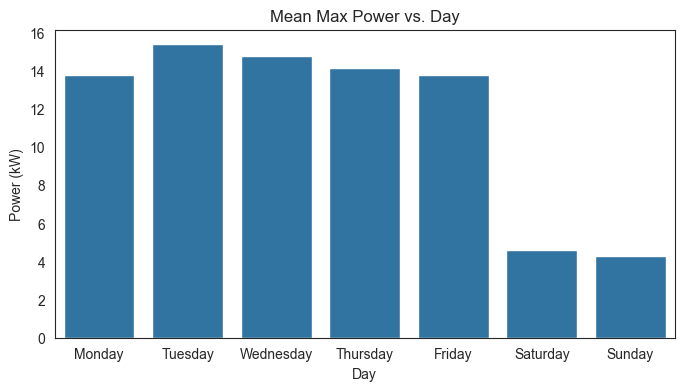

In [8]:
mean_power_day = dailydemand[["day", "peak_power_kW"]].groupby("day").mean()
plt.figure(figsize = (8,4))
sns.barplot(data = mean_power_day , x = mean_power_day.index , y = mean_power_day["peak_power_kW"], 
           order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday" , "Sunday"] )
plt.title("Mean Max Power vs. Day")
plt.ylabel("Power (kW)")
plt.xlabel("Day")
plt.show()

Plotting the ACF also shows spikes at lags of multiples of 7. Clearly, weekly seasonality is present.

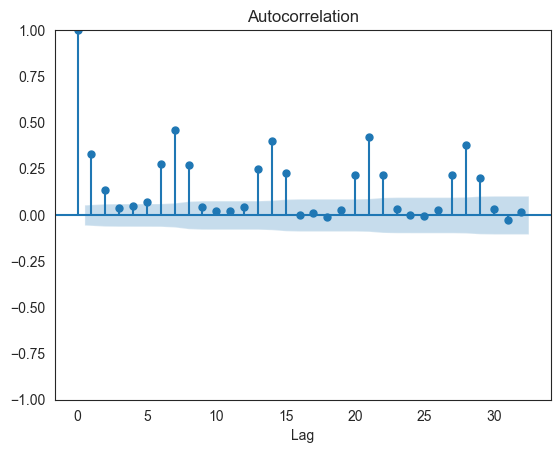

In [9]:
sm.graphics.tsa.plot_acf(dailydemand["peak_power_kW"])
plt.xlabel("Lag")
plt.show()

#### Distribution of Values

The empirical distribution for peak daily power is right tailed, while the empirical distributoin for weekly peak power is fairly symmetrical. 

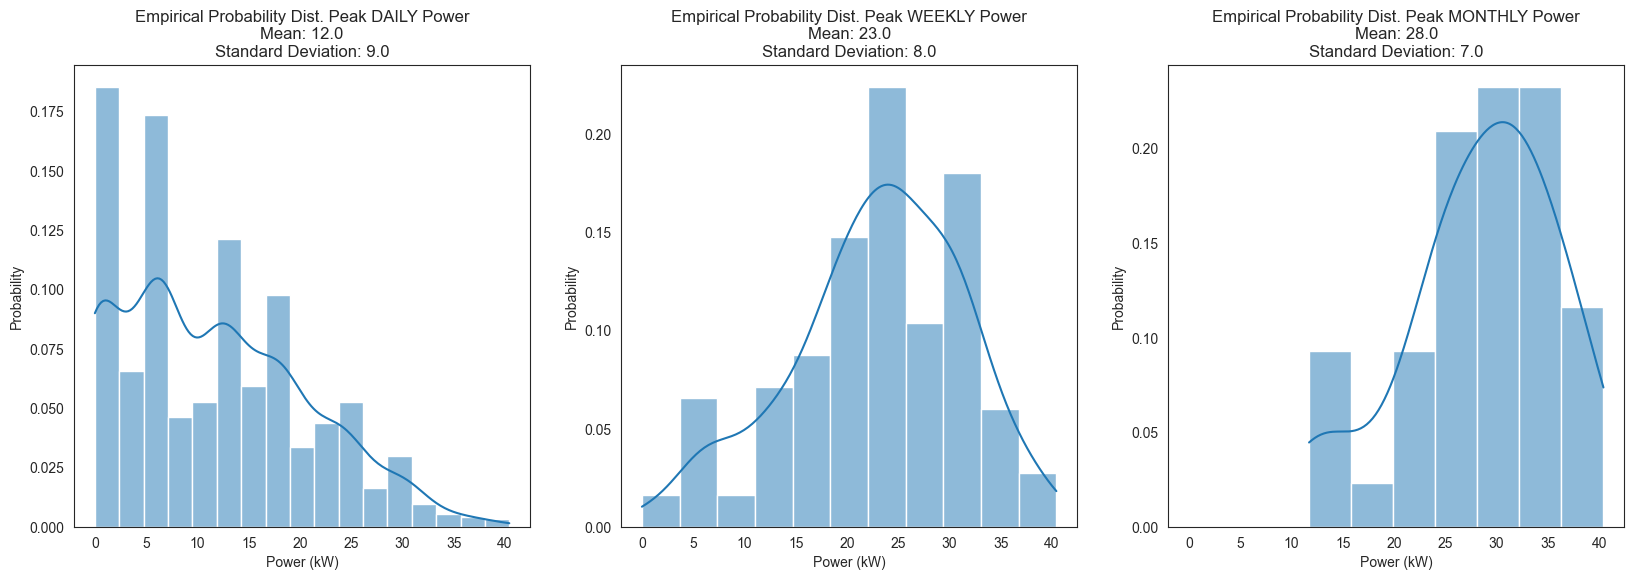

In [10]:
fig , ax = plt.subplots(1 , 3 , sharex = "all") # share axes
fig.set_size_inches(20, 6)

plt.subplot(1, 3 , 1)
sns.histplot(dailydemand["peak_power_kW"] , stat = 'probability' , kde = True)
plt.xlabel("Power (kW)")
plt.title(f'Empirical Probability Dist. Peak DAILY Power\nMean: {np.round(np.mean(dailydemand["peak_power_kW"]))}\
\nStandard Deviation: {np.round(np.std(dailydemand["peak_power_kW"]))}')

plt.subplot(1,3,2)
sns.histplot(dailydemand["peak_power_kW"].resample("1W").max() , stat = 'probability' ,  kde = True)
plt.xlabel("Power (kW)")
plt.title(f'Empirical Probability Dist. Peak WEEKLY Power\nMean: {np.round(np.mean(dailydemand["peak_power_kW"].resample("1W").max()))}\
\nStandard Deviation: {np.round(np.std(dailydemand["peak_power_kW"].resample("1W").max()))}')

plt.subplot(1,3,3)
sns.histplot(dailydemand["peak_power_kW"].resample("1M").max() , stat = 'probability' ,  kde = True)
plt.xlabel("Power (kW)")
plt.title(f'Empirical Probability Dist. Peak MONTHLY Power\nMean: {np.round(np.mean(dailydemand["peak_power_kW"].resample("1M").max()))}\
\nStandard Deviation: {np.round(np.std(dailydemand["peak_power_kW"].resample("1M").max()))}')

plt.show()

## Time Series Decomposition

One classical method of time series analysis is time series decomposition. Our time series is broken down into three components: trend, seasonality, and random noise. Here, we use the additive model : 

$Y_t = S_t + T_t + E_t$ 

Where $T_t$ represents trend in our time series, $S_t$ represents seasonality in our time series, and $E_t$ represents our residual, or random error.

We can use the ```tsa.seasonal_decompose``` method in the ```statsmodels``` library to break down our time series into the above decomposition. ```statsmodels``` uses moving averages to decompose time series. See [appendix](#Appendix) for more information.

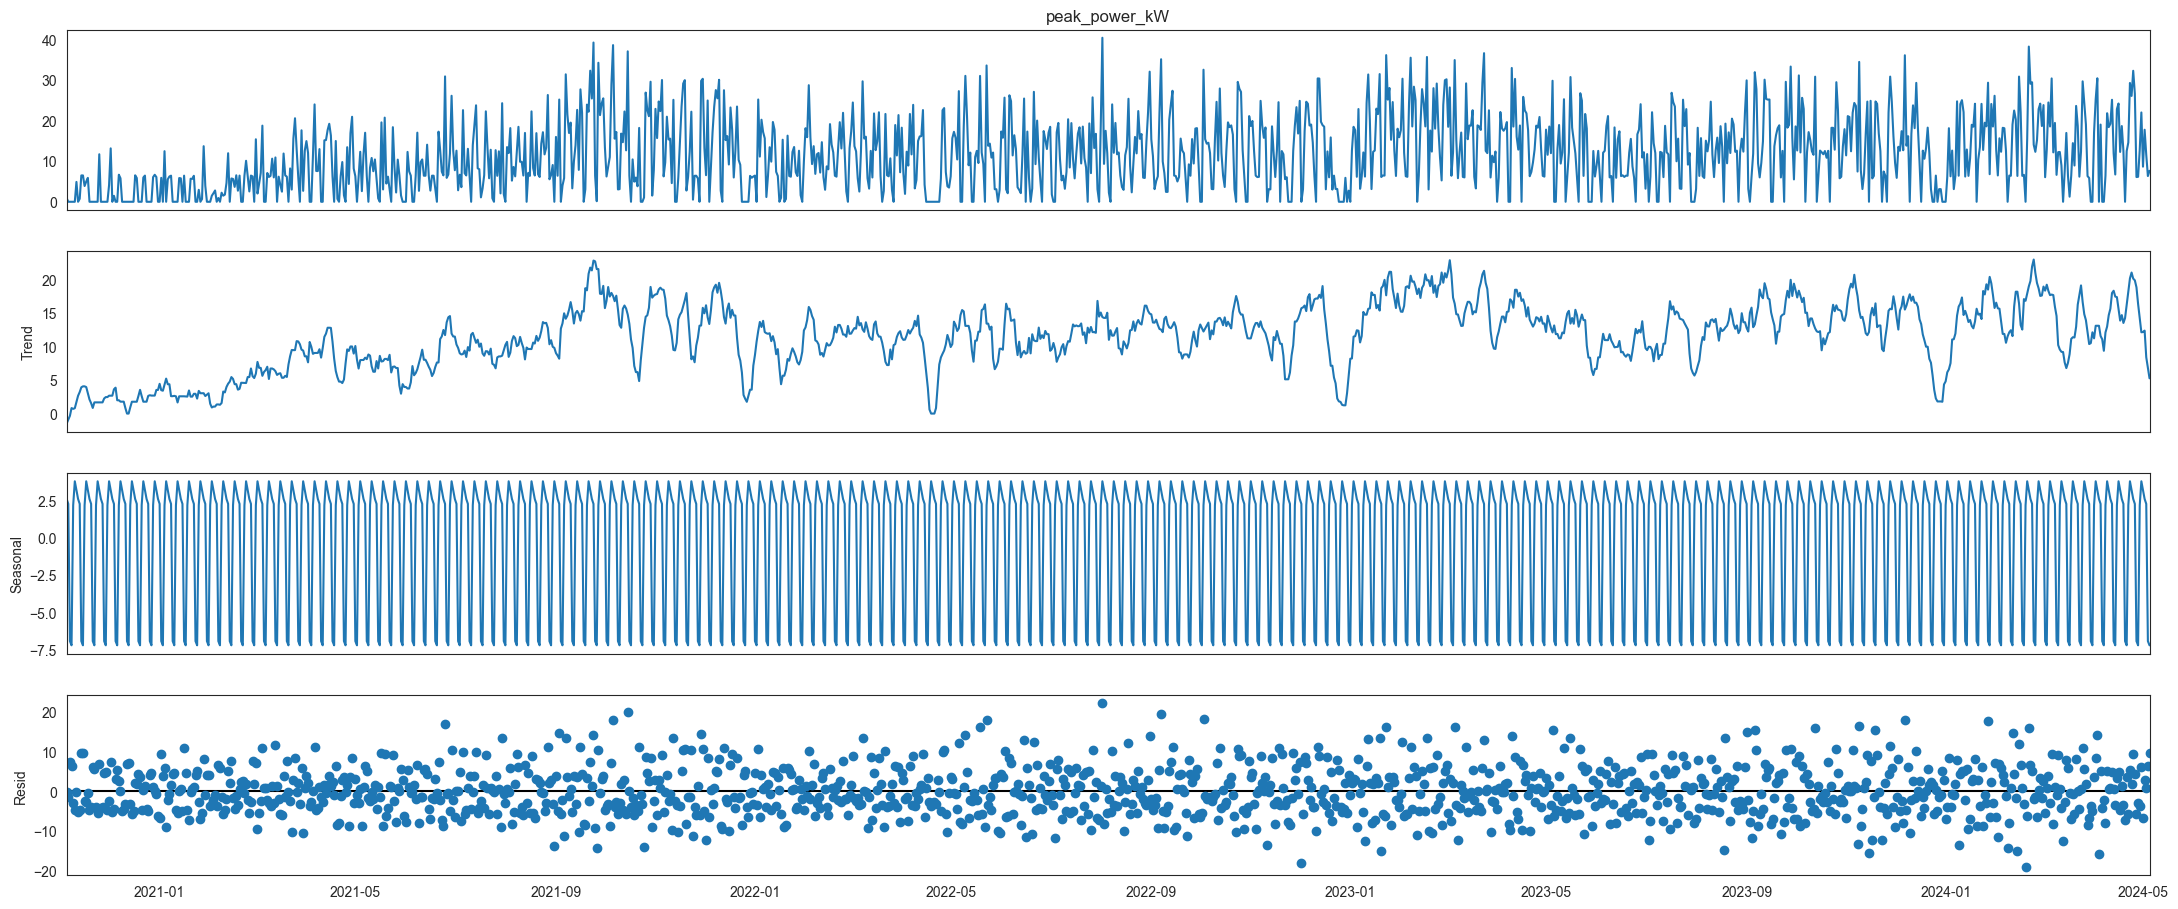

In [11]:
decomposed = sm.tsa.seasonal_decompose(x = dailydemand["peak_power_kW"] , model = 'additive' , period = 7 , extrapolate_trend = 'freq')
fig = decomposed.plot() # y-axis is in the same units as original time series, Power (W)
fig.set_size_inches(25, 10)
plt.show()

### Residuals

Let's take a closer look at the residuals, which ideally, should be normally distributed, with $\mu = 0$, finite variance, and serially uncorrelated. This particular combination is known as Gaussian White Noise. The PACF and ACF plots of the residuals should show no significant spikes.

Mean: 0.018084836402587186
STD: 6.109532033230145


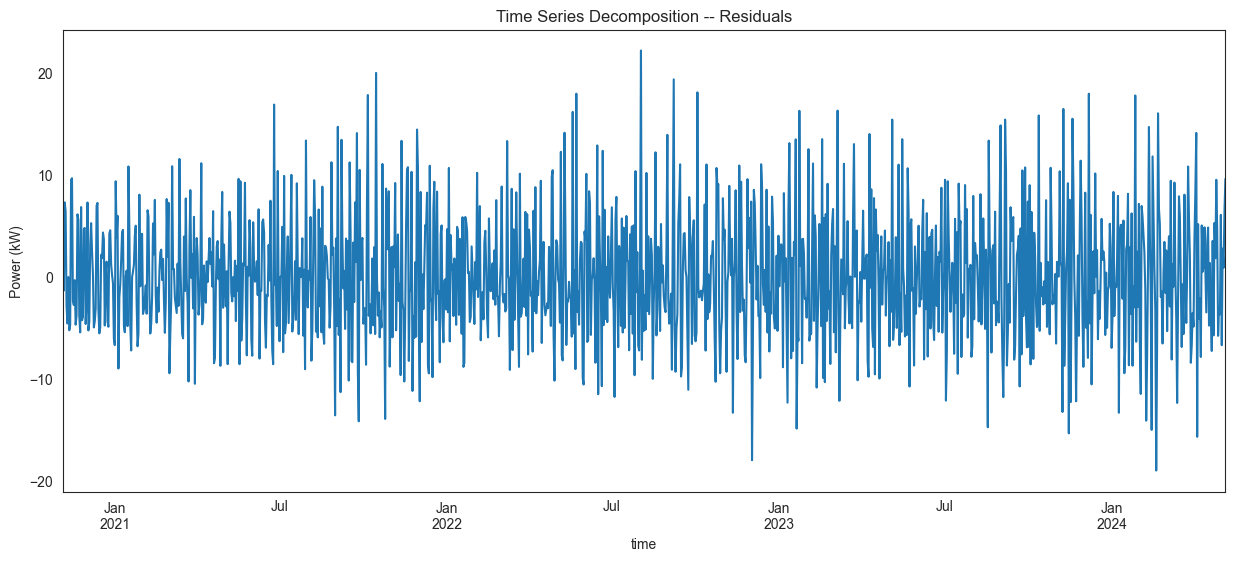

In [12]:
decomposed.resid.plot(figsize = (15, 6))
plt.ylabel("Power (kW)")
plt.title("Time Series Decomposition -- Residuals")
print("Mean:" , np.mean(decomposed.resid))
print("STD:" , np.std(decomposed.resid))
plt.show()

The residuals do display some significant auto- and partial autocorrelations, indicating our residuals may not be perfectly Gaussian White Noise.

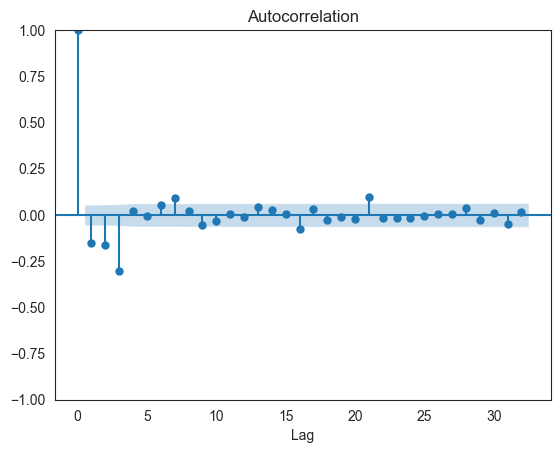

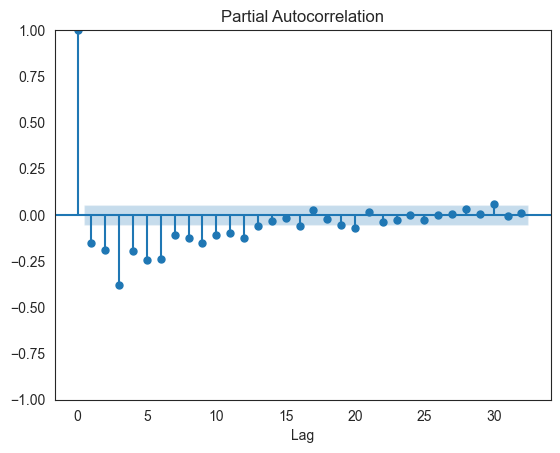

In [13]:
sm.graphics.tsa.plot_acf(decomposed.resid)
plt.xlabel("Lag")
plt.show()
sm.graphics.tsa.plot_pacf(decomposed.resid, method = "ywm")
plt.xlabel("Lag")
plt.show()

## SARIMA-X

(Seasonal Auto-Regressive Integrated Moving Average + Exogenous Variables)

### Stationarity 

A key first step in applying classical time series models is to transform our data to achieve stationarity. Stationarity is defined as a constant mean and (finite) variance over time. 

#### Differencing

Our data is weekly seasonal, so it is important to remove this seasonality before preceding. One method to remove seasonality is differencing, where each datapoint is subtracted from its last seasonal datapoint. Formally :

$Y_t^{'} = Y_t - Y_{t-7}$

Each datapoint is the difference between that day and the previous week's same day. Note that we will have 7 fewer datapoints in the differenced time series, as we cannot calculate a difference for the first 7 observations.


In [14]:
fig = px.line(data_frame = dailydemand["peak_power_kW"], x = dailydemand["peak_power_kW"].diff(periods = 7).dropna().index, 
              y = dailydemand["peak_power_kW"].diff(periods = 7).dropna())
fig.update_layout(title = "Weekly Differenced Max Power", xaxis_title = "Time", yaxis_title = "Power (kW)")
fig.show()

We can robustly check for stationarity using an Augmented Dickey-Fuller test. A negative test statistic and low p-value corresponds to a high probability that our time series is not stationarity.

In [15]:
adf_result = sm.tsa.stattools.adfuller(dailydemand["peak_power_kW"].diff(periods = 7).dropna())
print(f"Augmented Dickey-Fuller Test Statistic: {adf_result[0]}")
print(f"p-value: {adf_result[1]}")      

Augmented Dickey-Fuller Test Statistic: -11.031284572356979
p-value: 5.659821359809414e-20


### Autocorrelation Analysis

Autocorrelation function (ACF) and partial autocorrelation function (PACF) plots determine the parameters of an ARIMA model.

Let's plot the ACF and PACF of our time series.

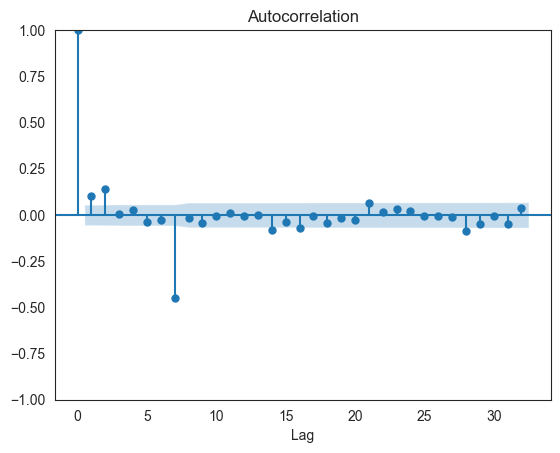

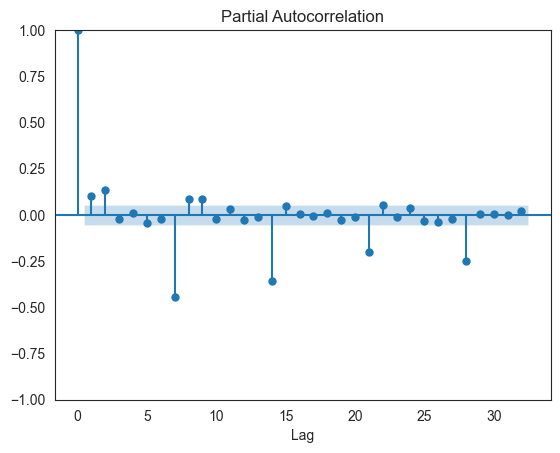

In [16]:
sm.graphics.tsa.plot_acf(dailydemand["peak_power_kW"].diff(periods = 7).dropna())
plt.xlabel("Lag")
plt.show()
sm.graphics.tsa.plot_pacf(dailydemand["peak_power_kW"].diff(periods = 7).dropna() , method = "ywm")
plt.xlabel("Lag")
plt.show()

### Train & Test Split

Let's split our dataset into a training set and test set, withholding 20% of our data. To maintain the temporality of our data, we'll use the first 80% of our data to train, using the last 20% to evaluate our model. 

We can ignore our `rollingavg7` feature here; if we're forecasting far into the future, as we won't have access to the true values' rolling average (we are forecasting far into the future).

In [18]:
X_train, X_test, y_train, y_test = train_test_split(
    dailydemand.drop(columns = ["peak_power_kW", "rollingavg7", "day"]), 
    dailydemand[["peak_power_kW"]], 
    test_size=0.2, 
    shuffle=False
)

### Optimal SARIMA-X Parameters

Normally, the optimal SARIMA-X order and seasonal order ($p$, $q$, $P$, and $Q$) are found by looking for patterns in the ACF and PACF plots. However, we can use the ```pmdarima``` library's ```auto_arima``` to grid search for the optimal parameters. However, $D$ is manually set to 1 (a 7th difference).

In [19]:
stepwise_fit = pm.auto_arima(y_train, start_p = 0, start_q = 0, max_p = 3, max_q = 3, max_Q = 3, max_P = 3, 
                             d = 0, D = 1, m = 7, 
                             X = None,
                             seasonal = True, trace = True , stepwise = True)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(1,1,1)[7] intercept   : AIC=6831.716, Time=2.38 sec
 ARIMA(0,0,0)(0,1,0)[7] intercept   : AIC=7360.580, Time=0.03 sec
 ARIMA(1,0,0)(1,1,0)[7] intercept   : AIC=7099.730, Time=0.43 sec
 ARIMA(0,0,1)(0,1,1)[7] intercept   : AIC=6811.228, Time=0.44 sec
 ARIMA(0,0,0)(0,1,0)[7]             : AIC=7358.669, Time=0.03 sec
 ARIMA(0,0,1)(0,1,0)[7] intercept   : AIC=7355.842, Time=0.33 sec
 ARIMA(0,0,1)(1,1,1)[7] intercept   : AIC=6813.036, Time=0.58 sec
 ARIMA(0,0,1)(0,1,2)[7] intercept   : AIC=6813.020, Time=0.87 sec
 ARIMA(0,0,1)(1,1,0)[7] intercept   : AIC=7103.271, Time=0.38 sec
 ARIMA(0,0,1)(1,1,2)[7] intercept   : AIC=6811.095, Time=1.90 sec
 ARIMA(0,0,1)(2,1,2)[7] intercept   : AIC=6811.782, Time=2.38 sec
 ARIMA(0,0,1)(1,1,3)[7] intercept   : AIC=6811.925, Time=2.90 sec
 ARIMA(0,0,1)(0,1,3)[7] intercept   : AIC=6813.826, Time=1.61 sec
 ARIMA(0,0,1)(2,1,1)[7] intercept   : AIC=6814.063, Time=1.15 sec
 ARIMA(0,0,1)(2,1,3)[7] intercept

With the optimal parameters, we can fit an SARIMA model to our training data, and additionally passing in ```Academic Break``` and ```Federal Holiday``` as exogenous variables.

In [20]:
best_model_arima = sm.tsa.arima.ARIMA(y_train, order = stepwise_fit.order, seasonal_order = stepwise_fit.seasonal_order)
fitted_arima = best_model_arima.fit()
fitted_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                           peak_power_kW   No. Observations:                 1022
Model:             ARIMA(1, 0, 1)x(2, 1, [1, 2, 3], 7)   Log Likelihood               -3374.304
Date:                                 Tue, 07 May 2024   AIC                           6764.607
Time:                                         19:27:29   BIC                           6803.988
Sample:                                     11-05-2020   HQIC                          6779.564
                                          - 08-23-2023                                         
Covariance Type:                                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9056      0.032     28.145      0.000       0.843       0.969
ma.L1         -0.7802      0.045    -17.178      0.000      -0.869      -0.691
ar.S.L7       -1.3627      0.119    -11.482      0.000      -1.595      -1.130
ar.S.L14      -0.7895      0.110     -7.189      0.000      -1.005      -0.574
ma.S.L7        0.4473      0.133      3.356      0.001       0.186       0.708
ma.S.L14      -0.4796      0.071     -6.717      0.000      -0.620      -0.340
ma.S.L21      -0.6610      0.115     -5.766      0.000      -0.886      -0.436
sigma2        44.6793      1.766     25.302      0.000      41.218      48.140
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                39.34
Prob(Q):                              0.94   Prob(JB):                         0.00
Heteroskedasticity (H):               1.51   Skew:                             0.38
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.59
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Classical

Here, we plot the in-sample SARIMA forecast as well as the out-of-sample prediction, overlaid on the true data. We can see the out-of-sample prediction converges to the sample mean for long forecasting periods, which is typical for SARIMA models and regression models in general; the model just doesn't "know" what will happen that far in the future, and in long-term forecasting, the average becomes the best estimate. Unfortunately, this fails to capture that high variance that our original data is capable of.

In [21]:
fig = go.Figure()
fig.add_trace(
    go.Scatter(x = dailydemand["peak_power_kW"].index , y = dailydemand["peak_power_kW"], name = "True Data", hovertext=dailydemand["day"])
)
fig.add_trace(
    go.Scatter(x = fitted_arima.predict().index, y = fitted_arima.predict() , name = "In-Sample SARIMA Forecast" , line= {"color":"#FF8C00"}, hovertext=dailydemand["day"])
)
fig.add_trace(
    go.Scatter(x = X_test.index, 
               y = fitted_arima.predict(start = y_test.index[0] , end = y_test.index[len(y_test) - 1], exog = X_test),  
               name = "Out-of-Sample SARIMA Forecast" , line= {"color":"Red"}, hovertext=dailydemand["day"].loc[dailydemand.index >= y_test.index[0]])
)
fig.update_layout({"title" : "Peak Power Prediction Forecast -- SARIMA-X" , "yaxis_title" : "Peak Daily Power (kW)"})
fig.show()
print('Test Set RMSE:', np.sqrt(np.mean((y_test["peak_power_kW"] - fitted_arima.predict(start = y_test.index[0] , end = y_test.index[len(y_test) - 1], exog = X_test))**2)), 'kW')

Test Set RMSE: 8.272053717701073 kW


##### Residuals

ACF and PACF of the residuals.

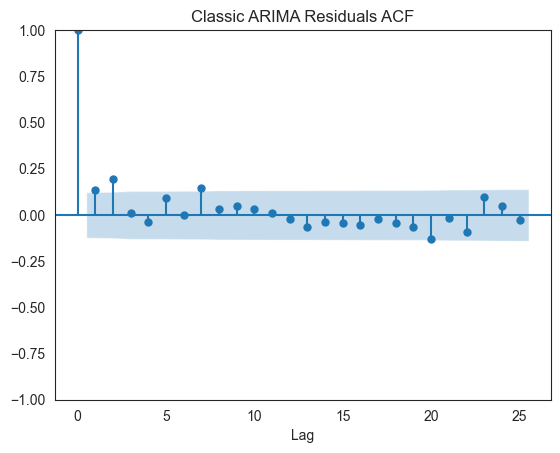

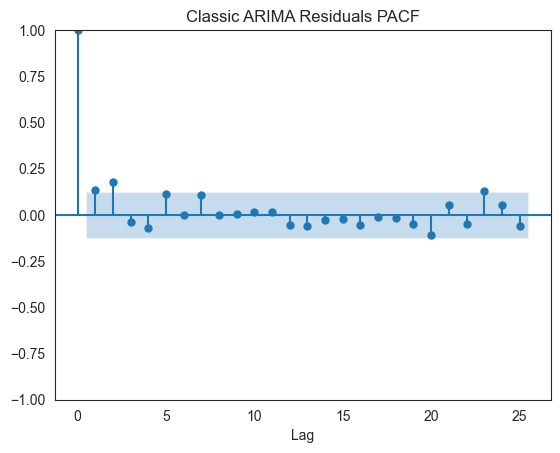

In [22]:
sm.graphics.tsa.plot_acf(y_test["peak_power_kW"] - fitted_arima.predict(start = y_test.index[0] , end = y_test.index[len(y_test) - 1], exog = X_test))
plt.xlabel("Lag")
plt.title("Classic ARIMA Residuals ACF")
plt.show()

sm.graphics.tsa.plot_pacf(y_test["peak_power_kW"] - fitted_arima.predict(start = y_test.index[0] , end = y_test.index[len(y_test) - 1], exog = X_test) , method = "ywm")
plt.xlabel("Lag")
plt.title("Classic ARIMA Residuals PACF")
plt.show()

In [23]:
residuals_df_ts = y_test["peak_power_kW"] - fitted_arima.predict(start = y_test.index[0] , end = y_test.index[len(y_test) - 1], exog = X_test)

fig = go.Figure()
fig.add_trace(
    go.Scatter(x = residuals_df_ts.index,
               y = residuals_df_ts)
)
fig.update_layout(title = "Test Set Residuals -- Classic SARIMA", xaxis_title = "Time", yaxis_title = "Power (kW)")
fig.show()
print("Residual Mean:", np.mean(residuals_df_ts))
print("Residual STD:", np.std(residuals_df_ts))

Residual Mean: 1.908186529197972
Residual STD: 8.048956260181786


### Rolling Forecast Origin

One alternative to avoid the convergence of SARIMA models is to use a rolling forecast origin. The idea is to only predict one period in the future (as opposed to predicting the entire values of our test set). After predicting a value, we use the true value to refit a model to predict the next value.

For example, 
we can train on days $1,2,\ldots,k-3$ to predict day $k-2$,

train on days $1,2,\ldots,k-3,k-2$ to predict day $k-1$ (taking into account the true value for day $k-2$),

and train on days $1,2,\ldots,k-3,k-2,k-1$ to predict day $k$ (taking into account the true values for days $k-2$ and $k-1$).

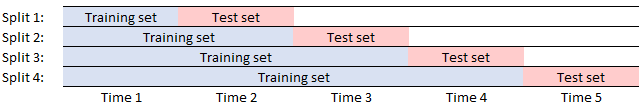


In [67]:
# this cell takes a while to run, depending on test size

# Initially split our data into training and test splits
train = dailydemand[:int(0.8*len(dailydemand)):][["peak_power_kW"]]
test = dailydemand[int(0.8*len(dailydemand))::][["peak_power_kW"]]

rolling_predictions = pd.Series(dtype=float)
model = None  

for train_end in test.index:

    # Move the training set up
    rolling_train = dailydemand[:train_end - timedelta(days=1)]
    
    # Extract x and Y training sets
    X_train_rolling = rolling_train.drop(columns=["peak_power_kW"])
    Y_train_rolling = rolling_train["peak_power_kW"]
    
    # Fit the initial ARIMA model
    if model is None:
        model = sm.tsa.arima.ARIMA(Y_train_rolling, order=stepwise_fit.order, seasonal_order=stepwise_fit.seasonal_order, exog=None).fit()

    else:
        # Update the model with the new data point
        model = model.append(test[test.index == train_end]["peak_power_kW"].to_list(), refit=True)
    
    # Predict a single value
    pred = model.forecast()
    rolling_predictions = pd.concat([rolling_predictions, pred])

rolling_predictions


2023-08-24    15.392343
2023-08-25    13.522112
2023-08-26     6.449718
2023-08-27     4.682616
2023-08-28    15.957040
                ...    
2024-05-01    17.855998
2024-05-02    17.746403
2024-05-03     5.659819
2024-05-04     6.603710
2024-05-05    14.918637
Freq: D, Length: 256, dtype: float64

We do get a greater variance in our predictions, but it still doesn't always capture the peaks in our data. 

In [68]:
fig = go.Figure()
fig.add_trace(
    go.Scatter(x = dailydemand["peak_power_kW"].index , y = dailydemand["peak_power_kW"], name = "True Data", hovertext = dailydemand["day"])
)
fig.add_trace(
    go.Scatter(x = fitted_arima.predict().index, y = fitted_arima.predict() , name = "In-Sample SARIMA Forecast" , line= {"color":"#FF8C00"}, hovertext=dailydemand["day"])
)
fig.add_trace(
    go.Scatter(x = rolling_predictions.index,
               y = rolling_predictions , name = "Out-of-Sample Rolling SARIMA Forecast" , line= {"color":"Red"}, 
               hovertext = dailydemand["day"].loc[dailydemand.index >= rolling_predictions.index[0]])
)
fig.update_layout({"title" : "Peak Power Rolling Prediction Forecast -- SARIMA-X" , "yaxis_title" : "Peak Daily Power (kW)"})
fig.show()
print(f'Test Set RMSE: {np.sqrt(np.mean((test["peak_power_kW"] - rolling_predictions)**2))} kW')

Test Set RMSE: 8.053536545703196 kW


##### Residuals

ACF and PACF of residuals (rolling forecast origin). 

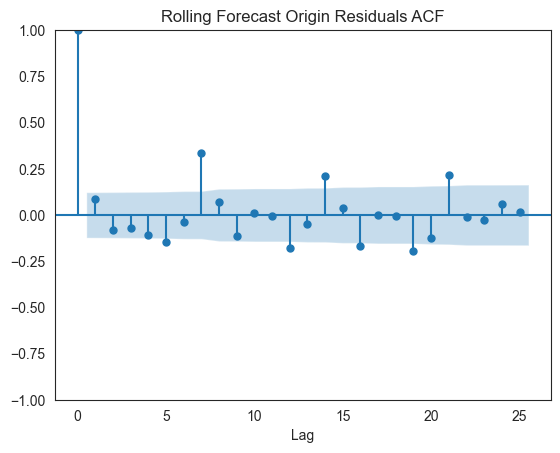

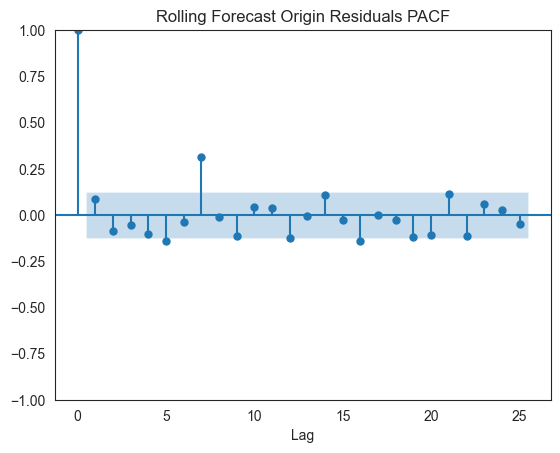

In [69]:
sm.graphics.tsa.plot_acf(test["peak_power_kW"] - rolling_predictions)
plt.xlabel("Lag")
plt.title("Rolling Forecast Origin Residuals ACF")
plt.show()

sm.graphics.tsa.plot_pacf(test["peak_power_kW"] - rolling_predictions , method = "ywm")
plt.xlabel("Lag")
plt.title("Rolling Forecast Origin Residuals PACF")
plt.show()

In [70]:
residuals_df_ts = test["peak_power_kW"] - rolling_predictions

fig = go.Figure()
fig.add_trace(
    go.Scatter(x = residuals_df_ts.index,
               y = residuals_df_ts)
)
fig.update_layout(title = "Test Set Residuals -- Rolling Forecast Origin SARIMA", xaxis_title = "Time", yaxis_title = "Power (kW)")
fig.show()
print("Residual Mean:", np.mean(residuals_df_ts))
print("Residual STD:", np.std(residuals_df_ts))

Residual Mean: 0.24496983398630487
Residual STD: 8.049809977472368
